# Pipelining in machine learning

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import tree
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

## Loading the dataset into memory

In [17]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, 
                                                    iris.target,
                                                    test_size=0.2, 
                                                    random_state=42)

## Constructing pipelines for data processing

`sklearn.pipeline.Pipeline(steps, memory=None)`

In [18]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', svm.SVC(random_state=42))])

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', tree.DecisionTreeClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}

## Fitting the data to the pipelines

In [19]:
# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
print('Saved %s pipeline to file' % pipe_dict[best_clf])


Logistic Regression pipeline test accuracy: 0.933
Support Vector Machine pipeline test accuracy: 0.900
Decision Tree pipeline test accuracy: 0.867
Classifier with best accuracy: Logistic Regression
Saved Logistic Regression pipeline to file


# Integrating pipeline with grid search

In [20]:
from sklearn.grid_search import GridSearchCV

### List of parameters for the decision tree classifier

In [21]:
print('Decision tree model hyperparameters:\n', pipe_dt.steps[2][1].get_params())

Decision tree model hyperparameters:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}


## Selected hyperparameters for grid search

* **criterion** - This is the function used to evaluate the quality of the split; we will use both options available in Scikit-learn: Gini impurity and information gain (entropy)


* **min_samples_leaf** - This is the minimum number of samples required for a valid leaf node; we will use the integer range 1 to 5


* **max_depth** - The is the maximum depth of the tree; we will use the integer range 1 to 5


* **min_samples_split** - This is the minimum number of samples required in order to split a non-leaf node; we will use the integer range 1 to 5


* **presort** - This indicates whether or not to presort the data in order to speed up the location of best splits during fitting; this does not have any effect on the resulting model accuracy (only on training times).

In [22]:
param_range = [1, 2, 3, 4, 5]

# Set grid search params
grid_params = [{'clf__criterion': ['gini', 'entropy'],
                'clf__min_samples_leaf': param_range,
                'clf__max_depth': param_range,
                'clf__min_samples_split': param_range[1:],
                'clf__presort': [True, False]}]

In [23]:
# Construct grid search
gs = GridSearchCV(estimator=pipe_dt,
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=10)

In [24]:
# Fit using grid search
gs.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best accuracy: 0.925

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__presort': True}


# Managing multiple models, pipelines and grid searches

In [13]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=2)),
                        ('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=2)),
                        ('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
                         ('pca', PCA(n_components=2)),
                         ('clf', svm.SVC(random_state=42))])


## Setting up the grid search parameters for each classifier

In [13]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': param_range_fl,
                   'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__min_samples_leaf': param_range,
                   'clf__max_depth': param_range,
                   'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
                    'clf__C': param_range}]


## Execution

In [15]:
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=grid_params_lr,
                     scoring='accuracy',
                     cv=10) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
                         param_grid=grid_params_lr,
                         scoring='accuracy',
                         cv=10)

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=grid_params_rf,
                     scoring='accuracy',
                     cv=10, 
                     n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                         param_grid=grid_params_rf,
                         scoring='accuracy',
                         cv=10, 
                         n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
                      param_grid=grid_params_svm,
                      scoring='accuracy',
                      cv=10,
                      n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
                          param_grid=grid_params_svm,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=jobs)


In [16]:
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]


grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
             2: 'Random Forest', 3: 'Random Forest w/PCA', 
             4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

## Fitting the grid search objects

In [19]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.967 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.858
Test set accuracy score for best params: 0.933 

Estimator: Random Forest
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best training accuracy: 0.942
Test set accuracy score for best params: 1.000 

Estimator: Random Forest w/PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.900 

Estimator: Support Vector Machine
Best params: {'clf__C': 3, 'clf__kernel': 'linear'}
Best training accuracy: 0.967
Test set acc

# On my own dataset

*In this notebook, First I have done some exploration on the data using matplotlib and seaborn.
Then, I use different classifier models to predict the quality of the wine.*

**1. Random Forest Classifier**

**2. Stochastic Gradient Descent Classifier**

**3. Support Vector Classifier(SVC) **

*Then I use cross validation evaluation technique to optimize the model performance.*

**1. Grid Search CV**

**2. Cross Validation Score**

In [6]:
#Loading dataset
wine = pd.read_csv('../Dataset/winequality-red.csv', sep=';')

In [7]:
#Let's check how the data is distributed
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
#Information about the data columns
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## **Let's do some plotting to know how the data columns are distributed in the dataset**

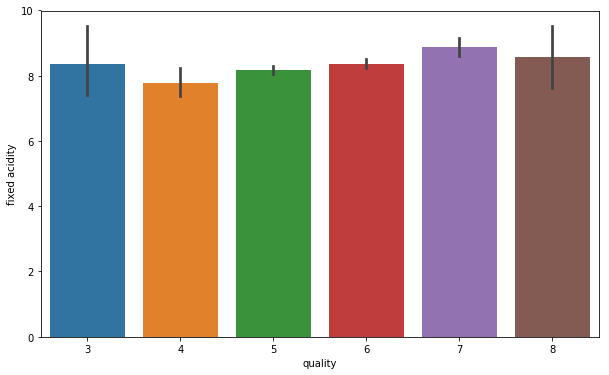

In [9]:
#Here we see that fixed acidity does not give any specification to classify the quality.
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'fixed acidity', data = wine)

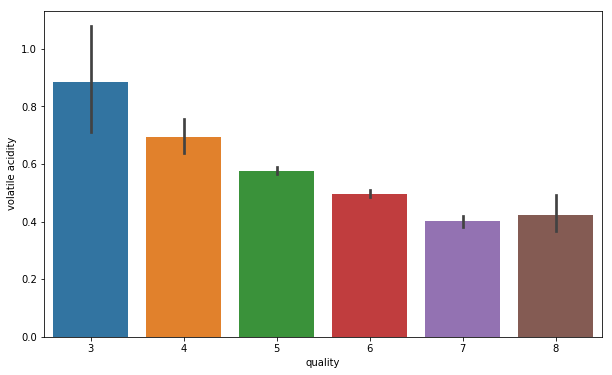

In [10]:
#Here we see that its quite a downing trend in the volatile acidity as we go higher the quality 
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'volatile acidity', data = wine)

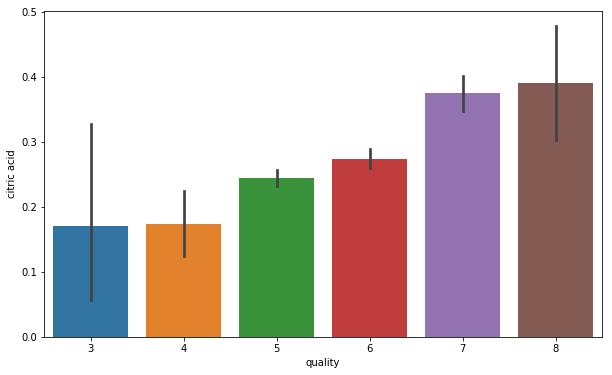

In [11]:
#Composition of citric acid go higher as we go higher in the quality of the wine
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'citric acid', data = wine)

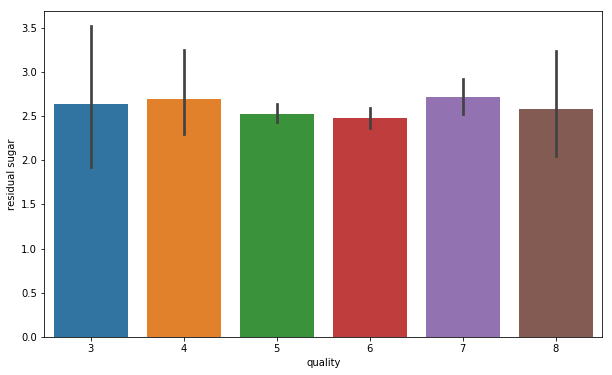

In [12]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'residual sugar', data = wine)

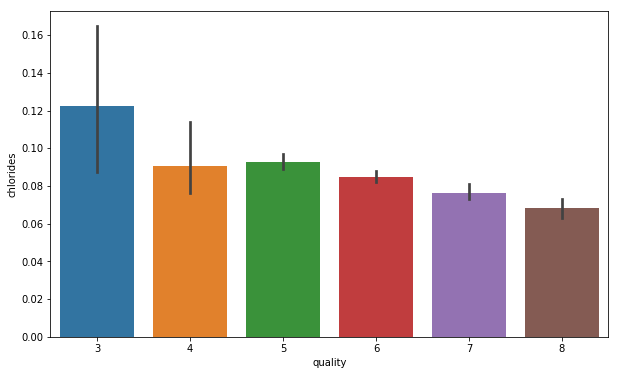

In [13]:
#Composition of chloride also go down as we go higher in the quality of the wine
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'chlorides', data = wine)

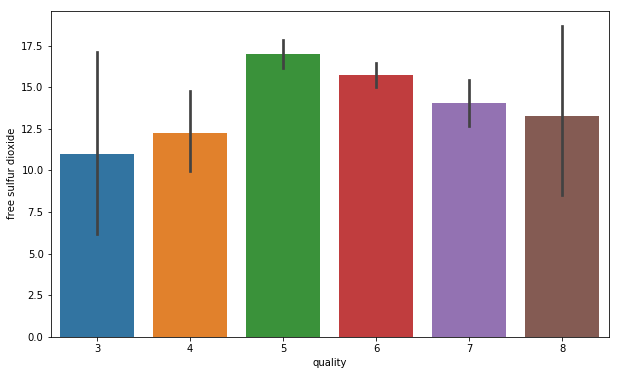

In [14]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'free sulfur dioxide', data = wine)

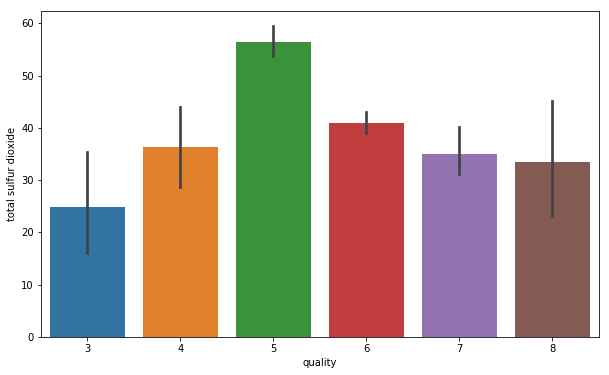

In [15]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'total sulfur dioxide', data = wine)

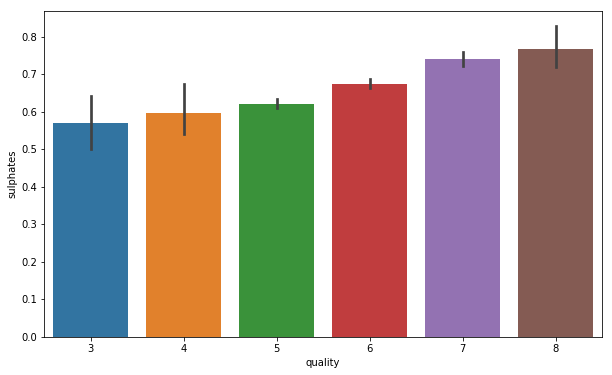

In [16]:
#Sulphates level goes higher with the quality of wine
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'sulphates', data = wine)

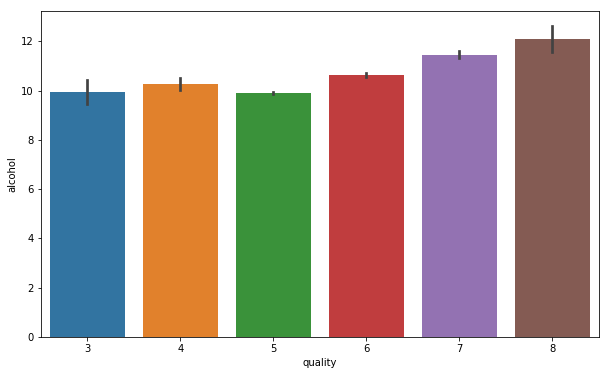

In [17]:
#Alcohol level also goes higher as te quality of wine increases
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'alcohol', data = wine)

## Preprocessing Data for performing Machine learning algorithms

In [18]:
#Making binary classificaion for the response variable.
#Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

In [19]:
#Now lets assign a labels to our quality variable
label_quality = LabelEncoder()

In [20]:
#Bad becomes 0 and good becomes 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [21]:
wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

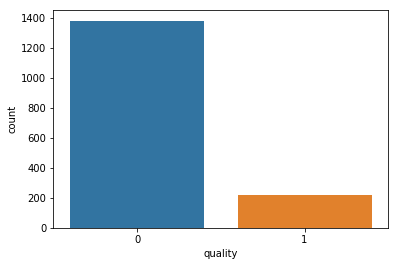

In [22]:
sns.countplot(wine['quality'])

In [23]:
#Now seperate the dataset as response variable and feature variabes
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [24]:
#Train and Test splitting of data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
#Applying Standard scaling to get optimized result
sc = StandardScaler()

In [26]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Our training and testing data is ready now to perform machine learning algorithm

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [28]:
#Let's see how our model performed
print(classification_report(y_test, pred_rfc))

             precision    recall  f1-score   support

          0       0.91      0.96      0.93       273
          1       0.65      0.43      0.51        47

avg / total       0.87      0.88      0.87       320



#### Random forest gives the accuracy of 87%

In [29]:
#Confusion matrix for the random forest classification
print(confusion_matrix(y_test, pred_rfc))

[[262  11]
 [ 27  20]]




## Stochastic Gradient Decent Classifier

In [30]:
sgd = SGDClassifier(penalty=None)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)

/home/prateek/anaconda3/envs/dltf/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [31]:
print(classification_report(y_test, pred_sgd))

             precision    recall  f1-score   support

          0       0.89      0.93      0.91       273
          1       0.47      0.34      0.40        47

avg / total       0.83      0.85      0.84       320



#### 84% accuracy using stochastic gradient descent classifier

In [32]:
print(confusion_matrix(y_test, pred_sgd))

[[255  18]
 [ 31  16]]


## Support Vector Classifier

In [33]:
svc = SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

In [34]:
print(classification_report(y_test, pred_svc))

             precision    recall  f1-score   support

          0       0.88      0.98      0.93       273
          1       0.71      0.26      0.37        47

avg / total       0.86      0.88      0.85       320



#### Support vector classifier gets 86%

## Grid Search CV

Trying out a pipeline with PCA and standard scaler

In [45]:
#Finding best parameters for our SVC model
param = {
    'clf__C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'clf__kernel':['linear', 'rbf'],
    'clf__gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}

pipeline_svc = Pipeline([('scl', StandardScaler()),
                         ('pca', PCA(n_components=3)),
                    ('clf', SVC())])

grid_svc = GridSearchCV(estimator=pipeline_svc, param_grid=param, scoring='accuracy', cv=10)

In [46]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4], 'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [47]:
#Best parameters for our svc model
grid_svc.best_params_

{'clf__C': 1.1, 'clf__gamma': 0.8, 'clf__kernel': 'rbf'}

In [48]:
#Let's run our SVC again with the best parameters.
svcp = SVC(C = 1.1, gamma =  0.8, kernel= 'rbf')
svcp.fit(X_train, y_train)
pred_svcp = svcp.predict(X_test)
print(classification_report(y_test, pred_svcp))

             precision    recall  f1-score   support

          0       0.89      0.99      0.94       273
          1       0.88      0.32      0.47        47

avg / total       0.89      0.89      0.87       320



In [39]:
#Finding best parameters for our SVC model
param = {
    'clf__C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'clf__kernel':['linear', 'rbf'],
    'clf__gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}

pipeline_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])

grid_svc = GridSearchCV(estimator=pipeline_svc, param_grid=param, scoring='accuracy', cv=10)

In [40]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4], 'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [41]:
#Best parameters for our svc model
grid_svc.best_params_

{'clf__C': 1.2, 'clf__gamma': 0.9, 'clf__kernel': 'rbf'}

In [42]:
#Let's run our SVC again with the best parameters.
svc2 = SVC(C = 1.2, gamma =  0.9, kernel= 'rbf')
svc2.fit(X_train, y_train)
pred_svc2 = svc2.predict(X_test)
print(classification_report(y_test, pred_svc2))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94       273
          1       0.89      0.34      0.49        47

avg / total       0.90      0.90      0.88       320



### SVC without PCA improves from 86% to 90% using Grid Search CV hence we would go forward with that

## Cross Validation Score for random forest and SGD

In [44]:
#Now lets try to do some evaluation for random forest model using cross validation.
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
rfc_eval.mean()

0.9093073326771653

### Random forest accuracy increases from 87% to 91 % using cross validation score